# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [36]:
env_info.vector_observations

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -6.14030886, -1.5       , -0.        ,  0.        ,
        -7.11741829,  5.96076012, -0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -7.9574213 , -1.5       ,  0.        ,  0.        ,
         7.11741829,  5.96076012,  0.        ,  0.        ]])

In [92]:
import itertools
list(itertools.chain.from_iterable(env_info.vector_observations))

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -6.140308856964111,
 -1.5,
 -0.0,
 0.0,
 -7.11741828918457,
 5.960760116577148,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -7.95742130279541,
 -1.5,
 0.0,
 0.0,
 7.11741828918457,
 5.960760116577148,
 0.0,
 0.0]

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.09000000171363354
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.09000000171363354
Score (max over agents) from episode 5: 0.0


In [206]:
actions = np.random.randn(num_agents, action_size)
actions

array([[ 0.25496995,  0.99271079],
       [ 1.06991674, -0.53127979]])

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [197]:
test = [[1,2,3],[1,2,3],[1,2,3],[1,2,3],[1,2,3]]
print("samples:",np.array(test).shape)

def transpose_list(mylist):
    return list(map(list, zip(*mylist)))

transpose_list(test)

samples: (5, 3)


[[1, 1, 1, 1, 1], [2, 2, 2, 2, 2], [3, 3, 3, 3, 3]]

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Network(nn.Module):
    def __init__(self, input_dim, hidden_in_dim, hidden_out_dim, output_dim, actor=False):
        super(Network, self).__init__()

        """self.input_norm = nn.BatchNorm1d(input_dim)
        self.input_norm.weight.data.fill_(1)
        self.input_norm.bias.data.fill_(0)"""

        self.fc1 = nn.Linear(input_dim,hidden_in_dim)
        self.fc2 = nn.Linear(hidden_in_dim,hidden_out_dim)
        self.fc3 = nn.Linear(hidden_out_dim,output_dim)
        self.nonlin = f.relu #leaky_relu
        self.actor = actor
        #self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-1e-3, 1e-3)

    def forward(self, x):
        if self.actor:
            # return a vector of the force
            h1 = self.nonlin(self.fc1(x))

            h2 = self.nonlin(self.fc2(h1))
            h3 = (self.fc3(h2))
            norm = torch.norm(h3)
            
            # h3 is a 2D vector (a force that is applied to the agent)
            # we bound the norm of the vector to be between 0 and 10
            return 10.0*(f.tanh(norm))*h3/norm if norm > 0 else 10*h3
        
        else:
            # critic network simply outputs a number
            h1 = self.nonlin(self.fc1(x))
            h2 = self.nonlin(self.fc2(h1))
            h3 = (self.fc3(h2))
            return h3

In [151]:
import numpy as np
import torch


# from https://github.com/songrotek/DDPG/blob/master/ou_noise.py
class OUNoise:

    def __init__(self, action_dimension, scale=0.1, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.scale = scale
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return torch.tensor(self.state * self.scale).float().to(device)

In [174]:
# individual network settings for each actor + critic pair
# see networkforall for details

#from networkforall import Network
from utilities import hard_update #, gumbel_softmax, onehot_from_logits
from torch.optim import Adam
import torch
import numpy as np


# add OU noise for exploration
#from OUNoise import OUNoise

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

class DDPGAgent:
    def __init__(self, in_actor, hidden_in_actor, hidden_out_actor, out_actor, in_critic, hidden_in_critic, hidden_out_critic, lr_actor=1.0e-2, lr_critic=1.0e-2):
        super(DDPGAgent, self).__init__()

        self.actor = Network(in_actor, hidden_in_actor, hidden_out_actor, out_actor, actor=True).to(device)
        self.critic = Network(in_critic, hidden_in_critic, hidden_out_critic, 1).to(device)
        self.target_actor = Network(in_actor, hidden_in_actor, hidden_out_actor, out_actor, actor=True).to(device)
        self.target_critic = Network(in_critic, hidden_in_critic, hidden_out_critic, 1).to(device)

        self.noise = OUNoise(out_actor, scale=1.0 )

        # initialize targets same as original networks
        hard_update(self.target_actor, self.actor)
        hard_update(self.target_critic, self.critic)

        self.actor_optimizer = Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=lr_critic, weight_decay=1.e-5)

    def act(self, obs, noise=0.0):
        #print("obs:", obs)
        obs = obs.to(device)
        action = self.actor(obs) + noise*self.noise.noise()
        return action

    def target_act(self, obs, noise=0.0):
        #obs = obs.to(device)
        action = self.target_actor(obs) + noise*self.noise.noise()
        return action

In [280]:
# main code that contains the neural network setup
# policy + critic updates
# see ddpg.py for other details in the network

#from ddpg import DDPGAgent
import torch
from utilities import soft_update, transpose_to_tensor#, transpose_list
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'


class MADDPG:
    def __init__(self, discount_factor=0.95, tau=0.02):
        super(MADDPG, self).__init__()

        # critic input = obs_full + actions = 14+2+2+2=20
        # def __init__(self, in_actor, hidden_in_actor, hidden_out_actor, out_actor, in_critic, hidden_in_critic, hidden_out_critic, lr_actor=1.0e-2, lr_critic=1.0e-2):
        #self.maddpg_agent = [DDPGAgent(14, 16, 8, 2, 20, 32, 16), 
        #                     DDPGAgent(14, 16, 8, 2, 20, 32, 16), 
        #                     DDPGAgent(14, 16, 8, 2, 20, 32, 16)]
        num_in_actor = state_size # <-------------------------------------------------
        num_in_critic = state_size*num_agents + action_size*num_agents  # <-------------------------------------------------
        num_out_actor = action_size
        self.agent = DDPGAgent(in_actor=num_in_actor, hidden_in_actor=16, 
                                       hidden_out_actor=8, out_actor=num_out_actor, 
                                       in_critic=num_in_critic, hidden_in_critic=32, hidden_out_critic=16)
        self.maddpg_agent = [self.agent, self.agent]
        """
        self.maddpg_agent = [DDPGAgent(in_actor=num_in_actor, hidden_in_actor=16, 
                                       hidden_out_actor=8, out_actor=num_out_actor, 
                                       in_critic=num_in_critic, hidden_in_critic=32, hidden_out_critic=16), 
                             DDPGAgent(in_actor=num_in_actor, hidden_in_actor=16, 
                                       hidden_out_actor=8, out_actor=num_out_actor, 
                                       in_critic=num_in_critic, hidden_in_critic=32, hidden_out_critic=16)]
        """
        
        self.discount_factor = discount_factor
        self.tau = tau
        self.iter = 0

    def get_actors(self):
        """get actors of all the agents in the MADDPG object"""
        actors = [ddpg_agent.actor for ddpg_agent in self.maddpg_agent]
        return actors

    def get_target_actors(self):
        """get target_actors of all the agents in the MADDPG object"""
        target_actors = [ddpg_agent.target_actor for ddpg_agent in self.maddpg_agent]
        return target_actors

    def act(self, obs_all_agents, noise=0.0):
        """get actions from all agents in the MADDPG object"""
        #print("obs_all_agents:", obs_all_agents)
        actions = [agent.act(obs, noise) for agent, obs in zip(self.maddpg_agent, obs_all_agents)]
        return actions

    def target_act(self, obs_all_agents, noise=0.0):
        """get target network actions from all the agents in the MADDPG object """
        target_actions = [ddpg_agent.target_act(obs, noise) for ddpg_agent, obs in zip(self.maddpg_agent, obs_all_agents)]
        return target_actions

    def update(self, samples, agent_number):
        """update the critics and actors of all the agents """

        # need to transpose each element of the samples
        # to flip obs[parallel_agent][agent_number] to
        # obs[agent_number][parallel_agent]
        #obs, obs_full, action, reward, next_obs, next_obs_full, done = map(transpose_to_tensor, samples)
        obs, obs_full, action, reward, next_obs, next_obs_full, done = samples
        
        #print("next_obs:",np.array(next_obs).shape)
        #print("next_obs:",next_obs)
        #print("action:",action)
        next_obs = transpose_list(next_obs)
        #print("After  - next_obs:",np.array(next_obs).shape)
        #print("After  - next_obs:",next_obs)
        reward = transpose_list(reward)
        done = transpose_list(done)
        
        ##action = np.clip(action, -1, 1)  
        action = transpose_list(action)
        obs = transpose_list(obs)
        #obs_full = transpose_list(obs_full)
        #print("transposed - action:",action)
        
        _, obs_full, _, _, _, next_obs_full, _ = map(to_tensor, samples)
        next_obs = to_tensor(next_obs)
        reward = to_tensor(reward)
        done = to_tensor(done)
        action = to_tensor(action)
        obs = to_tensor(obs)
        #obs_full = to_tensor(obs_full)
        #print("to tensor - action:",action)

        #print("obs_full:",np.array(obs_full).shape)
        #print("next_obs_full:",np.array(next_obs_full).shape)
        
        obs_full = torch.stack(obs_full)
        next_obs_full = torch.stack(next_obs_full)
        
        #print("stack - obs_full:",obs_full.size())
        #print("stack - next_obs_full:",next_obs_full.size())
        
        agent = self.maddpg_agent[agent_number]
        agent.critic_optimizer.zero_grad()

        #critic loss = batch mean of (y- Q(s,a) from target network)^2
        #y = reward of this timestep + discount * Q(st+1,at+1) from target network
        
        #print("next_obs:",np.array(next_obs).shape)
        
        #print("next_obs for TARGET ACT:",next_obs)
        
        ########################################################################################
        target_actions = self.target_act(next_obs)
        
        #print("org - target_actions:",np.array(target_actions).shape)
        #print("org - target_actions:",target_actions)
        
        target_actions = torch.cat(target_actions, dim=1)
        
        #print("torch - target_actions:",target_actions.size())
        #print("torch - target_actions:",target_actions)
        
        #target_critic_input = torch.cat((next_obs_full.t(),target_actions), dim=1).to(device)
        

        target_critic_input = torch.cat((next_obs_full,target_actions), dim=1).to(device)
        #print("target_critic_input:",target_critic_input.size())
        
        with torch.no_grad():
            q_next = agent.target_critic(target_critic_input)
        
        #print("q_next:",q_next.size())
        #print("self.discount_factor:",self.discount_factor)
        #print("done[agent_number]:",done[agent_number])
        
        y = reward[agent_number].view(-1, 1) + self.discount_factor * q_next * (1 - done[agent_number].view(-1, 1))
        
        action = torch.cat(action, dim=1)
        
        #critic_input = torch.cat((obs_full.t(), action), dim=1).to(device)
        
        #print("obs_full:",obs_full)
        
        critic_input = torch.cat((obs_full, action), dim=1).to(device)
        
        q = agent.critic(critic_input)

        huber_loss = torch.nn.SmoothL1Loss()
        critic_loss = huber_loss(q, y.detach())
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 0.5)
        agent.critic_optimizer.step()

        #update actor network using policy gradient
        agent.actor_optimizer.zero_grad()
        # make input to agent
        # detach the other agents to save computation
        # saves some time for computing derivative
        
        #print("obs:",obs)
        
        
        q_input = [ self.maddpg_agent[i].actor(ob) if i == agent_number \
                   else self.maddpg_agent[i].actor(ob).detach()
                   for i, ob in enumerate(obs) ]
                
        q_input = torch.cat(q_input, dim=1)
        # combine all the actions and observations for input to critic
        # many of the obs are redundant, and obs[1] contains all useful information already
        #q_input2 = torch.cat((obs_full.t(), q_input), dim=1)
        q_input2 = torch.cat((obs_full, q_input), dim=1)
        
        # get the policy gradient
        actor_loss = -agent.critic(q_input2).mean()
        actor_loss.backward()
        #torch.nn.utils.clip_grad_norm_(agent.actor.parameters(),0.5)
        agent.actor_optimizer.step()

        #al = actor_loss.cpu().detach().item()
        #cl = critic_loss.cpu().detach().item()

    def update_targets(self):
        """soft update targets"""
        self.iter += 1
        for ddpg_agent in self.maddpg_agent:
            soft_update(ddpg_agent.target_actor, ddpg_agent.actor, self.tau)
            soft_update(ddpg_agent.target_critic, ddpg_agent.critic, self.tau)

In [176]:
from utilities import transpose_list, transpose_to_tensor
mylist = np.array([[1,1],[2,2],[3,3]])
a, b = transpose_list(mylist)
a
b
obs_full = transpose_list(states)
obs_full

[[0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [-6.754833221435547, -6.4316911697387695],
 [-1.5, -1.5],
 [-0.0, 0.0],
 [0.0, 0.0],
 [-7.748623371124268, 7.748623371124268],
 [5.693928241729736, 5.693928241729736],
 [-0.0, 0.0],
 [0.0, 0.0]]

In [155]:
states

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -6.75483322, -1.5       , -0.        ,  0.        ,
        -7.74862337,  5.69392824, -0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -6.43169117, -1.5       ,  0.        ,  0.        ,
         7.74862337,  5.69392824,  0.        ,  0.        ]])

In [199]:
from collections import deque
import random
from utilities import transpose_list


class ReplayBuffer:
    def __init__(self,size):
        self.size = size
        self.deque = deque(maxlen=self.size)

    def push(self,transition):
        """push into the buffer"""
        self.deque.append(transition)
        #input_to_buffer = transpose_list(transition)
        #input_to_buffer = transition
    
        #for item in input_to_buffer:
        #    self.deque.append(item)

    def sample(self, batchsize):
        """sample from the buffer"""
        samples = random.sample(self.deque, batchsize)
    
        # transpose list of list
        return transpose_list(samples)
        #return samples

    def __len__(self):
        return len(self.deque)
    
    def sample_tensor(self, batchsize):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.deque, k=batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

In [157]:
# main function that sets up environments
# perform training loop

#import envs
#from buffer import ReplayBuffer
#from maddpg import MADDPG
import torch
import numpy as np
#from tensorboardX import SummaryWriter
import os
#from utilities import transpose_list, transpose_to_tensor

# keep training awake
#from workspace_utils import keep_awake

# for saving gif
#import imageio

def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

def pre_process(entity, batchsize):
    processed_entity = []
    for j in range(3):
        list = []
        for i in range(batchsize):
            b = entity[i][j]
            list.append(b)
        c = torch.Tensor(list)
        processed_entity.append(c)
    return processed_entity

In [158]:
def to_tensor(input_list):
    make_tensor = lambda x: torch.tensor(x, dtype=torch.float).to(device)
    return list(map(make_tensor, input_list))

test_list = [[1,2,3],[4,5,6]]
to_tensor(test_list)

[tensor([1., 2., 3.], device='cuda:0'), tensor([4., 5., 6.], device='cuda:0')]

In [281]:
def main(env, brain_name, print_every):
#def ddpg(agent, num_agents, n_episodes=1000, max_t=300, print_every=100, target_reward=TARGET_REWARD):
    
    scores_total = []                         # list containing scores from each episode
    try:
        return run_main(env, brain_name, print_every, scores_total)
    except KeyboardInterrupt:
        return scores_total


def run_main(env, brain_name, print_every, scores_total):
    
    #scores_total = []
    scores_window = deque(maxlen=print_every)  # last `print_every`(default:100) times scores
    
    max_t = 3000

    seeding()
    # number of parallel agents
    ## parallel_envs = 4
    # number of training episodes.
    # change this to higher number to experiment. say 30000.
    number_of_episodes = 3000
    #episode_length = 80
    batchsize = 1000
    
    # how many episodes to save policy and gif
    save_interval = 1000
    #t = 0
    
    # amplitude of OU noise
    # this slowly decreases to 0
    noise = 2
    noise_reduction = 0.9999

    # how many episodes before update
    episode_per_update = 20 # * parallel_envs

    # keep 5000 episodes worth of replay
    buffer = ReplayBuffer(int(1e5)) #5000*episode_length))
    
    # initialize policy and critic
    maddpg = MADDPG()

    agent0_reward = []
    agent1_reward = []
    
    score_list = []
    max_score = -1

    # training loop

    # use keep_awake to keep workspace from disconnecting
    #for episode in keep_awake(range(0, number_of_episodes, parallel_envs)):
    for episode in range(0, number_of_episodes): #, parallel_envs):

        #reward_this_episode = np.zeros((parallel_envs, 3))
        #reward_this_episode = np.zeros((1, 2))
        reward_this_episode = np.zeros(num_agents)
        #all_obs = env.reset() #
        #obs, obs_full = transpose_list(all_obs)
        ####
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        # the MADDPG paper explains that the critic of each individual DDPG agent should "look" at the actions and states of all the agents at training time. 
        # Given that, you have to build an observation_full and an action_full to accomplish that requirement; 
        # they simply concatenate all the observations and actions (respectively) of all the agents and use it as input for the critic).
        #obs_full = transpose_list(states)
        
        obs_full = states.flatten() #list(itertools.chain.from_iterable(states))
        ####

        #for calculating rewards for this particular episode - addition of all time steps

        # save info or not
        #save_info = ((episode) % save_interval < parallel_envs or episode==number_of_episodes-parallel_envs)
        frames = []
        tmax = 0
        
        #if save_info:
        #    frames.append(env.render('rgb_array'))

        
        #for episode_t in range(episode_length):
        for episode_t in range(max_t):

            #t += parallel_envs
            

            # explore = only explore for a certain number of episodes
            # action input needs to be transposed
            #actions = maddpg.act(transpose_to_tensor(obs), noise=noise)
            
            #print("states:", obs_full)
            #print("transpose_to_tensor(states):", transpose_to_tensor(obs_full))
            
            
            
            #actions = maddpg.act(transpose_to_tensor(obs_full), noise=noise)
            actions = maddpg.act(to_tensor(states), noise=noise)
            
            #obs_full = torch.from_numpy(obs_full).float().to(device)
            
            obs_full = torch.from_numpy(np.array(obs_full)).float().to(device)
            
            
            #actions = maddpg.act(obs_full, noise=noise)
            noise *= noise_reduction
            
            #actions_array = torch.stack(actions).detach().numpy()
            actions_array = torch.stack(actions).detach().cpu().numpy()

            # transpose the list of list
            # flip the first two indices
            # input to step requires the first index to correspond to number of parallel agents
            #actions_for_env = np.rollaxis(actions_array,1)
            #print("actions:",actions)
            # step forward one frame
            #next_obs, next_obs_full, rewards, dones, info = env.step(actions_for_env)
            ####
            
            #env_info = env.step(actions_for_env)[brain_name]           # send all actions to tne environment
            env_info = env.step(actions_array)[brain_name]           # send all actions to tne environment
            
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            
            
            #print("scores:", scores)
            if np.any(dones):                                  # exit loop if episode finished
                break
            
            # add data to buffer
            #transition = (obs, obs_full, actions_for_env, rewards, next_obs, next_obs_full, dones)
            #next_obs_full = transpose_list(states)
            
            next_obs_full = list(itertools.chain.from_iterable(next_states))
            actions_for_env = list(itertools.chain.from_iterable(actions_array))
            
            #print("next_states:", next_states)
            #print("states:", states)
            
            #transition = (states, obs_full, actions_for_env, rewards, next_states, next_obs_full, dones)
            transition = (states, obs_full, actions_array, rewards, next_states, next_obs_full, dones)
            
            
            buffer.push(transition)
            
            
            reward_this_episode += rewards

            #obs, obs_full = next_obs, next_obs_full
            
            # update once after every episode_per_update
            #if len(buffer) > batchsize and episode % episode_per_update < parallel_envs:
            if len(buffer) > batchsize and episode % episode_per_update == 0:
                #for a_i in range(3):
                for j in range(10):
                    for a_i in range(num_agents):
                        samples = buffer.sample(batchsize)
                        #maddpg.update(samples, a_i, logger)
                        #print("samples:",np.array(samples).shape)
                        maddpg.update(samples, a_i)
                    maddpg.update_targets() #soft update the target network towards the actual networks
            
            
            obs, obs_full = next_states, next_obs_full
            if np.any(dones): # exit loop if episode finished
                break
        
        scores_window.append(np.max(scores))  # save most recent score
        scores_total.append(np.max(scores))   # save most recent score
            
        #for i in range(parallel_envs):
        #for i in range(1):
        #    agent0_reward.append(reward_this_episode[i,0])
        #    agent1_reward.append(reward_this_episode[i,1])

        #if episode % 100 == 0 or episode == number_of_episodes-1:
        #    #avg_rewards = [np.mean(agent0_reward), np.mean(agent1_reward), np.mean(agent2_reward)]
        #    avg_rewards = [np.mean(agent0_reward), np.mean(agent1_reward)]
        #    agent0_reward = []
        #    agent1_reward = []

        #saving model
        #save_dict_list =[]

        print('\rScore (max/min over agents) from episode {}: {}/{}'.format(episode, np.max(scores), np.min(scores)), end="")
        if episode % print_every == 0:
            print('\rScore (max/min over agents) from episode {}: {}/{}'.format(episode, np.max(scores_window), np.min(scores_window)))
            if max_score < np.max(scores_window):
                max_score = np.max(scores_window)
                torch.save(maddpg.agent.actor.state_dict(), 'checkpoint_actor.pth')
                torch.save(maddpg.agent.critic.state_dict(), 'checkpoint_critic.pth')
    
        #total_scores.append(np.max(avg_rewards))

    return scores_total



Score (max/min over agents) from episode 0: 0.09000000171363354/0.09000000171363354
Score (max/min over agents) from episode 20: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 40: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 60: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 79: 0.0/-0.009999999776482582

c:\users\yoshi\anaconda3\envs\ml-agents\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Score (max/min over agents) from episode 80: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 100: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 120: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 140: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 160: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 180: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 200: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 220: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 240: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 260: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 280: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 300: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 320: 0.0/0.0009999999776482582
Score (max/min over agents) from episode 340: 0.0/0.0009999999776

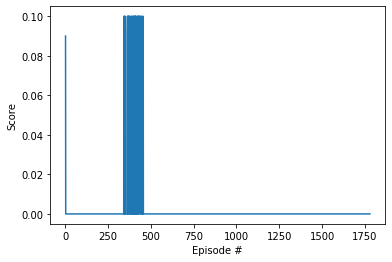

In [282]:
if __name__=='__main__':
    scores = main(env, brain_name, print_every=20)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

goal: an average score of +0.5 over 100 consecutive episodes, after taking maximim over both agents.

### 5. Watch a Smart Agent!
In the next code cell, you will load the trained weights from file to watch a smart agent!

In [289]:
def watch_agent(agent):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        #actions = []
        #for i in range(len(states)):
        #    action = agent.act(states[i])
        #    actions.append(action)
        actions = agent.act(to_tensor(states))#, noise=noise)
        actions_array = torch.stack(actions).detach().cpu().numpy()
        
        env_info = env.step(actions_array)[brain_name]

        #env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [290]:

# load the weights from file
maddpg = MADDPG()
maddpg.agent.actor.load_state_dict(torch.load('checkpoint_actor.pth'))
maddpg.agent.critic.load_state_dict(torch.load('checkpoint_critic.pth'))
watch_agent(maddpg)

Total score (averaged over agents) this episode: 0.04500000085681677


In [ ]:

env.close()